In [82]:
# Kaggle does not automatically have this
!pip install torch_geometric -q

In [83]:
import os
import sys
from tqdm import tqdm
from datetime import datetime
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.model_selection import TimeSeriesSplit

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch_geometric.data import Data, Batch

In [84]:
# Create submission folder if it doesn't exist
submission_dir = './submission'
os.makedirs(submission_dir, exist_ok=True)

# Uncomment the following block ONLY if you wish to inspect file paths in a Kaggle-like directory structure.
# On your local system, you likely have the files in your local folder so this is not needed.
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


# Data Loading for Local Environment
# Files are assumed to be in:
# ./cse-251-b-2025/train.npz
# ./cse-251-b-2025/test_input.npz

running_on_kaggle = True

if running_on_kaggle:
    train_file = np.load("/kaggle/input/cse-251-b-2025/train.npz")
    test_file = np.load("/kaggle/input/cse-251-b-2025/test_input.npz")
else:
    train_file = np.load("./cse-251-b-2025/train.npz")
    test_file = np.load("./cse-251-b-2025/test_input.npz")

train_data = train_file['data']
test_data = test_file['data']

print("train_data's shape:", train_data.shape)  # Expected shape: (10000, 50, 110, 6)
print("test_data's shape:", test_data.shape)    # Expected shape: (2100, 50, 50, 6)

train_data's shape: (10000, 50, 110, 6)
test_data's shape: (2100, 50, 50, 6)


# Visualization: 

In [85]:
# Run visualizations?
run_visualizations: bool = False

# From data loading notebook
def plot_one_training_scene(idx: int = 0):
    # Plot trajectories from one training scene (static plot)
    data_matrix = train_data[idx]

    plt.figure(figsize=(8, 8))
    for agent in range(data_matrix.shape[idx]):
        xs = data_matrix[agent, :, 0]
        ys = data_matrix[agent, :, 1]
        # Remove zeros (padding)
        xs = xs[xs != 0]
        ys = ys[ys != 0]
        plt.plot(xs, ys, alpha=0.7)
    plt.title("Trajectories from one training scene")
    plt.xlabel("x-coordinate")
    plt.ylabel("y-coordinate")
    plt.show()

# Create an animated gif for one training scene (exact code provided on kaggle)
def make_gif(data_matrix, name='example'):
    cmap = None
    if sys.version_info.minor <= 7:
        cmap = plt.cm.get_cmap("viridis", 50)
    else:
        cmap = plt.get_cmap("viridis", 50)

    fig, ax = plt.subplots(figsize=(10, 10))
    # Function to update plot for each frame
    def update(frame):
        ax.clear()
        # Get data for current timestep
        for i in range(1, data_matrix.shape[0]):
            x = data_matrix[i, frame, 0]
            y = data_matrix[i, frame, 1]
            if x != 0 and y != 0:
                xs = data_matrix[i, :frame+1, 0]  # Include current frame
                ys = data_matrix[i, :frame+1, 1]  # Include current frame
                # trim all zeros
                mask = (xs != 0) & (ys != 0)  # Only keep points where both x and y are non-zero
                xs = xs[mask]
                ys = ys[mask]
                # Only plot if we have points to plot
                if len(xs) > 0 and len(ys) > 0:
                    color = cmap(i)
                    ax.plot(xs, ys, alpha=0.9, color=color)
                    ax.scatter(x, y, s=80, color=color)
        ax.plot(data_matrix[0, :frame, 0], data_matrix[0, :frame, 1],
                color='tab:orange', label='Ego Vehicle')
        ax.scatter(data_matrix[0, frame, 0], data_matrix[0, frame, 1],
                   s=80, color='tab:orange')
        # Set title with timestep
        ax.set_title(f'Timestep {frame}')
        # Set consistent axis limits
        ax.set_xlim(data_matrix[:,:,0][data_matrix[:,:,0] != 0].min() - 10, 
                    data_matrix[:,:,0][data_matrix[:,:,0] != 0].max() + 10)
        ax.set_ylim(data_matrix[:,:,1][data_matrix[:,:,1] != 0].min() - 10, 
                    data_matrix[:,:,1][data_matrix[:,:,1] != 0].max() + 10)
        ax.legend()
        return ax.collections + ax.lines

    # Create animation
    anim = animation.FuncAnimation(fig, update, frames=list(range(0, data_matrix.shape[1], 3)),
                                   interval=100, blit=True)
    # Save as GIF
    anim.save(f'trajectory_visualization_{name}.gif', writer='pillow')
    plt.close()

if run_visualizations:
    plot_one_training_scene(0)
    make_gif(train_data[0], 'index0')

# Constant velocity from test set
Untouched from original data loading notebook.

In [86]:
# Run constant velocity model (Kaggle score of ~50)?
run_constant_velocity_model: bool = False

if run_constant_velocity_model:
    # Compute the velocity differences for the ego vehicle (agent index 0)
    velocity_diff = test_data[..., 1:, :2] - test_data[..., :-1, :2]
    print("Velocity difference shape:", velocity_diff.shape)

    # Compute average velocity for the ego vehicle (index 0) in each scene
    constant_vel = np.mean(velocity_diff[:, 0, :, :], axis=1)
    print("Constant velocity shape:", constant_vel.shape)

    # Generate predictions for 60 future time steps based on constant velocity
    pred_y_const = np.zeros((test_data.shape[0], 60, 2))
    starting_point = test_data[:, 0, -1, :2]  # Last observed position of ego vehicle

    for t in range(60):
        pred_y_const[:, t, :] = starting_point + (t + 1) * constant_vel

    # Reshape predictions to submission format: (2100, 60, 2) -> (12600, 2)
    pred_output_const = pred_y_const.reshape(-1, 2)
    output_df_const = pd.DataFrame(pred_output_const, columns=['x', 'y'])
    output_df_const.index.name = 'index'
    # Save output in the submission folder
    constant_vel_path = os.path.join(submission_dir, 'constant_vel_submission.csv')
    output_df_const.to_csv(constant_vel_path)
    print(f"Constant velocity submission saved locally as '{constant_vel_path}'.")

# Our Work

In [87]:
# MLP model with residual blocks: ineffective for TimeSeries data
class BasicMLP(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()

        # Lazy layers infer the input size instead of having to explicitly pass it in
        # Backbone: linear -> BatchNorm -> PReLU -> Dropout
        self.net = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.BatchNorm1d(1024),
            nn.PReLU(),
            nn.Dropout(0.2),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.PReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.PReLU(),
            nn.Dropout(0.2),
        ) # Note: residual width must match the last width of the net

        # Residual block added to avoid vanishing gradient issue
        self.residual = nn.Sequential(
            nn.LazyLinear(256),
            nn.ReLU(),
            nn.LazyLinear(256),
        )

        # Infer last input shape, then do final projection (60*2)
        self.head = nn.LazyLinear(output_features)

    def forward(self, x):
        # Original forward loop
        # # (batch, 50, 50, 6) or flattened already
        # x = x.view(x.size(0), -1)
        # h = self.net(x) #(batch, 256)
        # h = h + self.residual(h)  # residual skip
        # return self.head(h) #(batch, 120)

        # Taken from milestone notebook (tensor format)
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        # x = x[:, :, :, :2] # (batch, 50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 6)
        x = self.net(x)
        x = x + self.residual(x)
        x = self.head(x)
        return x.view(-1, 60, 2)

In [88]:
# Base LSTM given to us in the milestone notebook
class BaseLSTM(nn.Module):
    def __init__(self, input_dim:int =6, hidden_dim:int =128, output_dim:int =60 * 2, dropout:float = 0):
        super(BaseLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)

In [89]:
# Multi agent scene context model
class SceneContextModel(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.agent_encoder = nn.Sequential(
            nn.Linear(50 * 6, hidden_dim),
            nn.ReLU()
        )
        self.ego_encoder = nn.Sequential(
            nn.Linear(50 * 6, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 60 * 2)
        )

    def forward(self, x_flat):
        # x = data.x
        # x = x[:, :, :, :2] # (batch, 50, 50, 2)
        # x = x.reshape(-1, 50 * 50 * 6)
        # x = self.mlp(x)
        # return x.view(-1, 60, 2)
        # In case you passed in a DataBatch
        if not isinstance(x_flat, torch.Tensor):
            x_flat = x_flat.x

        B = x_flat.size(0)
        x = x_flat.view(B, 50, 50, 6) #(B, agents, timesteps, features)
        x_agents = x.view(B, 50, -1)  #(B, 50, 300)
        agent_feats = self.agent_encoder(x_agents) #(B, 50, hidden_dim)
        scene_context = agent_feats.mean(dim=1) #(B, hidden_dim)

        ego_input = x[:, 0, :, :].reshape(B, -1) #(B, 300)
        ego_feat = self.ego_encoder(ego_input) #(B, hidden_dim)

        combined = torch.cat([ego_feat, scene_context], dim=1)

        out = self.decoder(combined) #(B, 120)
        return out.view(-1, 60, 2)

In [90]:
# Extended from the base LSTM model
class LSTMWithMLP(nn.Module):
    def __init__(self, input_dim:int =6, hidden_dim:int =128, output_dim:int =60 * 2, dropout:float = 0):
        super(LSTMWithMLP, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
        )
        self.fc = nn.Linear(64, output_dim)

    def forward(self, x):
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        x = self.net(lstm_out[:, -1, :])
        x = self.fc(x)
        return x.view(-1, 60, 2)

In [91]:
class LSTMButTwo(nn.Module):
    def __init__(self, input_dim:int =6, hidden_dim:int =128, output_dim:int =60 * 2, dropout:float = 0):
        super(LSTMButTwo, self).__init__()
        self.second_out_dim = 128

        self.lstm_1 = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)

        self.residual = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.ReLU(),
            nn.Linear(256, self.second_out_dim),
        )
        
        self.lstm_2 = nn.LSTM(hidden_dim, self.second_out_dim, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(self.second_out_dim, output_dim)

    def forward(self, x):
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_first_out, _ = self.lstm_1(x)
        residual = self.residual(lstm_first_out)
        lstm_second_out, _ = self.lstm_2(lstm_first_out)
        lstm_plus_res = lstm_second_out + residual

        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        lstm_out = lstm_plus_res[:, -1, :]
        x = self.fc(lstm_out)
        return x.view(-1, 60, 2)

# Preparing data

`TrajectoryDataset*` are taken from the milestone notebook.

In [92]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                # future = future @ R gives DeprecationWarning: future a torch.Tensor
                future = torch.from_numpy(np.dot(future.numpy(), R)) 
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        # future = future - origin -> same DeprecationWarning
        future = torch.from_numpy(future.numpy() - origin)

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

# Training loop

Change which model is used at the `model = ...(input_features, output_features)` line.

Change which optimizer is used at the `optimizer = optim...` line.

Do **NOT** change the `criterion`, as MSE is stated in the Data tab of the competition.

In [93]:
# Taken from milestone notebook
# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')
    print("Using CPU")

Using CUDA GPU


In [94]:
# Functions to save and load the model (should correspond to what was trained!)
def save_model(model, path="our_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")


def load_model(model_instance, path="our_model.pth"):
    loaded_model = model_instance
    loaded_model.load_state_dict(torch.load(path))
    loaded_model.eval()
    return loaded_model


# Example usage:
# save_model(trained_model)
# model = load_model()

In [95]:
def get_timestamp() -> str:
    return datetime.now().strftime("%Y-%m-%d_%I-%M%p")

In [96]:
# Set up hyperparameters

# Calculate number of input features after flattening and number of output features
# Note: LSTM models take features in different dimensions
input_features:int = 50 * 50 * 6   # 50 agents, 50 time steps, 6 dimensions each (15000 input features)
output_features:int = 60 * 2       # 60 future time steps, 2 dimensions (x, y) (120 output features)

# Hyperparameters
batch_size: int = 32
num_folds: int = 4
early_stopping_patience: int = 25
early_stopping_threshold: float = 1e-5
epochs: int = 150
starting_lr: float = 5e-3
scale: float = 10.0
weight_decay: float = 1e-2

lstm_hidden_dim: int = 128


SEED: int = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [97]:
# IMPORTANT! To change which model is used: comment/uncomment below
# Easily swap models by changing what is returned (called in training and test to avoid conflicts)
def get_model():
    global lstm_hidden_dim, input_features, output_features

    # return BasicMLP(input_features, output_features).to(device)
    # return BaseLSTM(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features).to(device)
    # return SceneContextModel(hidden_dim=864).to(device)
    # return LSTMWithMLP(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features).to(device)
    return LSTMButTwo(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features).to(device)

In [98]:
def train_model(full_training_data: np.ndarray, 
                batch_size:int = 64, epochs:int = 10, num_folds:int = 5,
                early_stopping_patience:int = 5, early_stopping_threshold:float = 1e-3):
    global starting_lr, gamma, scale, lstm_hidden_dim, output_features, weight_decay

    # Time series data needs to keep its data in relative order, so no shuffling can occur
    #   like in regular KFold cross validation
    splitter = TimeSeriesSplit(n_splits=num_folds, test_size=int(0.15 * len(full_training_data)))

    # Perform cross-validation, the best model will be saved as "best_model.pt" to be loaded in later
    overall_best_val_loss = float("inf")
    overall_best_seen_at = (0, 0) #(epoch, fold)

    # Resources used:
    # Project milestone notebook
    # https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md
    # https://www.geeksforgeeks.org/time-series-cross-validation/
    for fold_i, (train_idx, val_idx) in enumerate(splitter.split(full_training_data)):
        print(f"\nFOLD {fold_i + 1}/{num_folds} ==================================")

        # Create the model, loss criterion, and optimizer (reset per fold, to find the best model)
        # If you change the model here, ensure its the same in the test loop!
        # DO NOT CHANGE CRITERION
        criterion = nn.MSELoss()

        model = get_model()
        optimizer = optim.AdamW(model.parameters(), lr=starting_lr, weight_decay=weight_decay)
        schedulers: list[lr_scheduler.LRScheduler] =[
            lr_scheduler.ExponentialLR(optimizer, gamma=0.995),
            lr_scheduler.MultiStepLR(
                optimizer,
                milestones= list(range(25, epochs, 25)),
                gamma=0.80,
            ),
            # lr_scheduler.MultiStepLR(
            #     optimizer,
            #     milestones= list(range(100, epochs, 100)),
            #     gamma=0.5,
            # ),
            lr_scheduler.CosineAnnealingLR(
                optimizer, 
                T_max= int(epochs * 0.9),
                # T_0 = 50,
                # T_mult = 2,
                eta_min=1e-6
            ),
        ]

        # Prepare data from this fold
        train_fold: np.ndarray = full_training_data[train_idx]
        val_fold: np.ndarray = full_training_data[val_idx]
        collate_func = None     # Optional for DataLoader, taken from milestone notebook
        if not isinstance(model, SceneContextModel):
            # LSTM can handle the timeseries data directly
            # TrajectoryDataset expects numpy arrays
            collate_func = lambda x: Batch.from_data_list(x)
            train_dataset = TrajectoryDatasetTrain(train_fold, scale=scale, augment=True)
            val_dataset = TrajectoryDatasetTrain(val_fold, scale=scale, augment=False)
        else:
            train_x: np.ndarray = train_fold[..., :50, :]
            train_y: np.ndarray = train_fold[:, 0, 50:, :2]
            X_train_tensor = torch.FloatTensor(train_x).reshape((-1, input_features))
            y_train_tensor = torch.FloatTensor(train_y).reshape((-1, output_features))
            train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

            val_x: np.ndarray = val_fold[..., :50, :]
            val_y: np.ndarray = val_fold[:, 0, 50:, :2]
            X_val_tensor = torch.FloatTensor(val_x).reshape((-1, input_features))
            y_val_tensor = torch.FloatTensor(val_y).reshape((-1, output_features))
            val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_func)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_func)

        best_val_loss: float = float("inf")
        no_improvement: int = 0

        # Training and validation loops are taken from the milestone notebook,
        #   with modifications to allow for different data loading shapes      
        for epoch in tqdm(range(epochs), desc="Epoch", unit="epoch"):
            # Training loop
            model.train()
            train_loss = 0
            for batch in train_dataloader:
                batch_x = None
                batch_y = None
                if isinstance(batch, tuple) or isinstance(batch, list):
                    batch_x, batch_y = batch
                    batch_y = batch_y.view(-1, 60, 2)
                else: # DataBatch type
                    batch = batch.to(device)
                    batch_x = batch.x
                    batch_y = batch.y.view(batch.num_graphs, 60, 2)

                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
                optimizer.step()
                train_loss += loss.item()

            # Validation loop
            model.eval()
            val_loss = 0
            val_mae = 0
            val_mse = 0
            with torch.no_grad():
                for batch in val_dataloader:
                    batch_x = None
                    batch_y = None
                    if isinstance(batch, tuple) or isinstance(batch, list):
                        batch_x, batch_y = batch
                        batch_y = batch_y.view(-1, 60, 2)
                    else: # DataBatch type
                        batch = batch.to(device)
                        batch_x = batch.x
                        batch_y = batch.y.view(batch.num_graphs, 60, 2)

                    pred = model(batch_x)
                    val_loss += criterion(pred, batch_y).item()

                    # show MAE and MSE with unnormalized data
                    y = None
                    if isinstance(batch, tuple) or isinstance(batch, list):
                        y = batch_y.view(-1, 60, 2)
                    else: # DataBatch type
                        pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                        y = batch_y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                    val_mae += nn.L1Loss()(pred, y).item()
                    val_mse += nn.MSELoss()(pred, y).item()

            train_loss /= len(train_dataloader)
            val_loss /= len(val_dataloader)
            val_mae /= len(val_dataloader)
            val_mse /= len(val_dataloader)

            if (epoch + 1) % 5 == 0:
                tqdm.write(f"Epoch {(epoch + 1):03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")

            if val_loss < best_val_loss - early_stopping_threshold:
                best_val_loss = val_loss
                no_improvement = 0

                # Better than the overall seen so far?
                if best_val_loss < overall_best_val_loss:
                    overall_best_val_loss = best_val_loss
                    overall_best_seen_at = (epoch + 1, fold_i + 1)
                    torch.save(model.state_dict(), "best_model.pt")
            else:
                no_improvement += 1
                if no_improvement >= early_stopping_patience:
                    print(f"==== EARLY STOP at epoch {(epoch + 1):03d}")
                    break

            for sched in schedulers:
                sched.step()

        # Clean up after the fold finishes to prevent slower folds later
        # https://discuss.pytorch.org/t/how-to-delete-a-tensor-in-gpu-to-free-up-memory/48879
        torch.cuda.empty_cache()
        del train_dataloader, train_dataset, val_dataloader, val_dataset

    print(f"BEST VALIDATION LOSS (NORMALIZED MSE) SEEN: {overall_best_val_loss}, AT (epoch, fold) = {overall_best_seen_at}")

In [99]:
# Load in the model saved during testing to use on X_test
# Mostly taken from milestone notebook
def predict(X_test: np.ndarray, best_model_path: str = "best_model.pt"):
    global scale, batch_size, lstm_hidden_dim, output_features

    # Ensure this aligns with the trained model!
    best_model = torch.load(best_model_path)
    model = get_model()
    model.load_state_dict(best_model)
    model.eval()

    pred_list = []
    with torch.no_grad():
        if not isinstance(model, SceneContextModel): # Using DataBatch type from a DataLoader
            collate_func = lambda x: Batch.from_data_list(x)
            test_dataset = TrajectoryDatasetTest(X_test, scale=scale)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_func)

            for batch in test_loader:
                batch = batch.to(device)
                pred_norm = model(batch.x)

                # Reshape the prediction to (N, 60, 2)
                pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
                pred_list.append(pred.cpu().numpy())
        else:
            X_test_tensor = torch.FloatTensor(X_test).reshape((-1, input_features)).to(device)
            pred = model(X_test_tensor).cpu().reshape((-1, 60, 2))
            pred_list.append(pred.numpy())

    # Reshape predictions to match submission format: (2100, 60, 2) -> (12600, 2)
    pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
    pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
    output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
    output_df.index.name = 'index'
    return output_df

In [100]:
# Train the model (tweak batch_size and epochs as needed at top of this block)
# Saved as "best_model.pt" to be loaded in during testing
train_model(train_data, batch_size=batch_size, epochs=epochs, num_folds=num_folds,
            early_stopping_patience=early_stopping_patience,
            early_stopping_threshold=early_stopping_threshold)


FOLD 1/4 ==================================


Epoch:   3%|▎         | 5/150 [00:17<08:14,  3.41s/epoch]

Epoch 005 | Learning rate 0.004890 | train normalized MSE   0.2152 | val normalized MSE   0.1964, | val MAE   2.3734 | val MSE  19.6435


Epoch:   7%|▋         | 10/150 [00:33<07:51,  3.37s/epoch]

Epoch 010 | Learning rate 0.004727 | train normalized MSE   0.1847 | val normalized MSE   0.1811, | val MAE   2.4031 | val MSE  18.1093


Epoch:  10%|█         | 15/150 [00:50<07:28,  3.32s/epoch]

Epoch 015 | Learning rate 0.004539 | train normalized MSE   0.2090 | val normalized MSE   0.1796, | val MAE   2.4931 | val MSE  17.9625


Epoch:  13%|█▎        | 20/150 [01:07<07:15,  3.35s/epoch]

Epoch 020 | Learning rate 0.004327 | train normalized MSE   0.1462 | val normalized MSE   0.1275, | val MAE   1.8539 | val MSE  12.7476


Epoch:  17%|█▋        | 25/150 [01:24<07:03,  3.38s/epoch]

Epoch 025 | Learning rate 0.004097 | train normalized MSE   0.1260 | val normalized MSE   0.1343, | val MAE   2.0548 | val MSE  13.4294


Epoch:  20%|██        | 30/150 [01:41<06:43,  3.37s/epoch]

Epoch 030 | Learning rate 0.003080 | train normalized MSE   0.1081 | val normalized MSE   0.1112, | val MAE   1.6541 | val MSE  11.1179


Epoch:  23%|██▎       | 35/150 [01:58<06:30,  3.40s/epoch]

Epoch 035 | Learning rate 0.002872 | train normalized MSE   0.1098 | val normalized MSE   0.1030, | val MAE   1.5700 | val MSE  10.3031


Epoch:  27%|██▋       | 40/150 [02:14<06:12,  3.39s/epoch]

Epoch 040 | Learning rate 0.002658 | train normalized MSE   0.1021 | val normalized MSE   0.1051, | val MAE   1.6978 | val MSE  10.5115


Epoch:  30%|███       | 45/150 [02:32<05:58,  3.41s/epoch]

Epoch 045 | Learning rate 0.002439 | train normalized MSE   0.0995 | val normalized MSE   0.1028, | val MAE   1.6893 | val MSE  10.2817


Epoch:  33%|███▎      | 50/150 [02:49<05:39,  3.40s/epoch]

Epoch 050 | Learning rate 0.002218 | train normalized MSE   0.0951 | val normalized MSE   0.0954, | val MAE   1.5456 | val MSE   9.5388


Epoch:  37%|███▋      | 55/150 [03:06<05:26,  3.44s/epoch]

Epoch 055 | Learning rate 0.001598 | train normalized MSE   0.0921 | val normalized MSE   0.0950, | val MAE   1.5435 | val MSE   9.5002


Epoch:  40%|████      | 60/150 [03:23<05:07,  3.41s/epoch]

Epoch 060 | Learning rate 0.001425 | train normalized MSE   0.0893 | val normalized MSE   0.0962, | val MAE   1.5594 | val MSE   9.6172


Epoch:  43%|████▎     | 65/150 [03:40<04:51,  3.43s/epoch]

Epoch 065 | Learning rate 0.001256 | train normalized MSE   0.0869 | val normalized MSE   0.0882, | val MAE   1.4497 | val MSE   8.8202


Epoch:  47%|████▋     | 70/150 [03:57<04:31,  3.39s/epoch]

Epoch 070 | Learning rate 0.001093 | train normalized MSE   0.0848 | val normalized MSE   0.0896, | val MAE   1.5155 | val MSE   8.9607


Epoch:  50%|█████     | 75/150 [04:14<04:14,  3.39s/epoch]

Epoch 075 | Learning rate 0.000938 | train normalized MSE   0.0832 | val normalized MSE   0.0850, | val MAE   1.3927 | val MSE   8.5029


Epoch:  53%|█████▎    | 80/150 [04:31<03:59,  3.42s/epoch]

Epoch 080 | Learning rate 0.000634 | train normalized MSE   0.0811 | val normalized MSE   0.0864, | val MAE   1.4121 | val MSE   8.6398


Epoch:  57%|█████▋    | 85/150 [04:48<03:40,  3.39s/epoch]

Epoch 085 | Learning rate 0.000526 | train normalized MSE   0.0787 | val normalized MSE   0.0849, | val MAE   1.3807 | val MSE   8.4863


Epoch:  60%|██████    | 90/150 [05:05<03:24,  3.41s/epoch]

Epoch 090 | Learning rate 0.000427 | train normalized MSE   0.0774 | val normalized MSE   0.0828, | val MAE   1.3606 | val MSE   8.2773


Epoch:  63%|██████▎   | 95/150 [05:22<03:06,  3.39s/epoch]

Epoch 095 | Learning rate 0.000338 | train normalized MSE   0.0763 | val normalized MSE   0.0811, | val MAE   1.3370 | val MSE   8.1106


Epoch:  67%|██████▋   | 100/150 [05:39<02:49,  3.39s/epoch]

Epoch 100 | Learning rate 0.000259 | train normalized MSE   0.0754 | val normalized MSE   0.0817, | val MAE   1.3333 | val MSE   8.1740


Epoch:  70%|███████   | 105/150 [05:56<02:31,  3.36s/epoch]

Epoch 105 | Learning rate 0.000152 | train normalized MSE   0.0747 | val normalized MSE   0.0803, | val MAE   1.3173 | val MSE   8.0276


Epoch:  73%|███████▎  | 110/150 [06:13<02:16,  3.42s/epoch]

Epoch 110 | Learning rate 0.000106 | train normalized MSE   0.0740 | val normalized MSE   0.0803, | val MAE   1.3118 | val MSE   8.0326


Epoch:  77%|███████▋  | 115/150 [06:30<01:58,  3.38s/epoch]

Epoch 115 | Learning rate 0.000069 | train normalized MSE   0.0729 | val normalized MSE   0.0799, | val MAE   1.3080 | val MSE   7.9904


Epoch:  80%|████████  | 120/150 [06:46<01:41,  3.38s/epoch]

Epoch 120 | Learning rate 0.000040 | train normalized MSE   0.0728 | val normalized MSE   0.0803, | val MAE   1.3131 | val MSE   8.0314


Epoch:  83%|████████▎ | 125/150 [07:03<01:23,  3.35s/epoch]

Epoch 125 | Learning rate 0.000019 | train normalized MSE   0.0721 | val normalized MSE   0.0799, | val MAE   1.3030 | val MSE   7.9940


Epoch:  87%|████████▋ | 130/150 [07:20<01:07,  3.38s/epoch]

Epoch 130 | Learning rate 0.000005 | train normalized MSE   0.0717 | val normalized MSE   0.0799, | val MAE   1.3022 | val MSE   7.9913


Epoch:  90%|█████████ | 135/150 [07:37<00:50,  3.39s/epoch]

Epoch 135 | Learning rate 0.000001 | train normalized MSE   0.0728 | val normalized MSE   0.0798, | val MAE   1.3012 | val MSE   7.9808


Epoch:  93%|█████████▎| 140/150 [07:54<00:33,  3.35s/epoch]

Epoch 140 | Learning rate 0.000011 | train normalized MSE   0.0731 | val normalized MSE   0.0797, | val MAE   1.3010 | val MSE   7.9726


Epoch:  97%|█████████▋| 145/150 [08:11<00:16,  3.36s/epoch]

Epoch 145 | Learning rate 0.000052 | train normalized MSE   0.0717 | val normalized MSE   0.0802, | val MAE   1.3129 | val MSE   8.0181


Epoch: 100%|██████████| 150/150 [08:28<00:00,  3.39s/epoch]


Epoch 150 | Learning rate 0.000122 | train normalized MSE   0.0731 | val normalized MSE   0.0799, | val MAE   1.3169 | val MSE   7.9861

FOLD 2/4 ==================================


Epoch:   3%|▎         | 5/150 [00:22<10:39,  4.41s/epoch]

Epoch 005 | Learning rate 0.004890 | train normalized MSE   0.2070 | val normalized MSE   0.2044, | val MAE   2.4443 | val MSE  20.4408


Epoch:   7%|▋         | 10/150 [00:44<10:22,  4.44s/epoch]

Epoch 010 | Learning rate 0.004727 | train normalized MSE   0.1708 | val normalized MSE   0.1722, | val MAE   2.2647 | val MSE  17.2221


Epoch:  10%|█         | 15/150 [01:06<10:01,  4.45s/epoch]

Epoch 015 | Learning rate 0.004539 | train normalized MSE   0.1469 | val normalized MSE   0.1599, | val MAE   2.1836 | val MSE  15.9948


Epoch:  13%|█▎        | 20/150 [01:28<09:34,  4.42s/epoch]

Epoch 020 | Learning rate 0.004327 | train normalized MSE   0.1184 | val normalized MSE   0.1363, | val MAE   1.8483 | val MSE  13.6329


Epoch:  17%|█▋        | 25/150 [01:50<09:15,  4.45s/epoch]

Epoch 025 | Learning rate 0.004097 | train normalized MSE   0.1080 | val normalized MSE   0.1265, | val MAE   1.9307 | val MSE  12.6540


Epoch:  20%|██        | 30/150 [02:12<08:47,  4.40s/epoch]

Epoch 030 | Learning rate 0.003080 | train normalized MSE   0.0995 | val normalized MSE   0.1228, | val MAE   1.8473 | val MSE  12.2827


Epoch:  23%|██▎       | 35/150 [02:34<08:26,  4.41s/epoch]

Epoch 035 | Learning rate 0.002872 | train normalized MSE   0.0963 | val normalized MSE   0.1163, | val MAE   1.6686 | val MSE  11.6274


Epoch:  27%|██▋       | 40/150 [02:57<08:08,  4.44s/epoch]

Epoch 040 | Learning rate 0.002658 | train normalized MSE   0.0946 | val normalized MSE   0.1180, | val MAE   1.8113 | val MSE  11.8018


Epoch:  30%|███       | 45/150 [03:19<07:46,  4.44s/epoch]

Epoch 045 | Learning rate 0.002439 | train normalized MSE   0.0928 | val normalized MSE   0.1170, | val MAE   1.7685 | val MSE  11.7041


Epoch:  33%|███▎      | 50/150 [03:41<07:21,  4.42s/epoch]

Epoch 050 | Learning rate 0.002218 | train normalized MSE   0.0890 | val normalized MSE   0.1103, | val MAE   1.6671 | val MSE  11.0320


Epoch:  37%|███▋      | 55/150 [04:03<07:01,  4.44s/epoch]

Epoch 055 | Learning rate 0.001598 | train normalized MSE   0.0856 | val normalized MSE   0.1021, | val MAE   1.5227 | val MSE  10.2104


Epoch:  40%|████      | 60/150 [04:25<06:33,  4.37s/epoch]

Epoch 060 | Learning rate 0.001425 | train normalized MSE   0.0828 | val normalized MSE   0.1029, | val MAE   1.4791 | val MSE  10.2928


Epoch:  43%|████▎     | 65/150 [04:47<06:17,  4.44s/epoch]

Epoch 065 | Learning rate 0.001256 | train normalized MSE   0.0819 | val normalized MSE   0.1054, | val MAE   1.6227 | val MSE  10.5352


Epoch:  47%|████▋     | 70/150 [05:10<05:55,  4.45s/epoch]

Epoch 070 | Learning rate 0.001093 | train normalized MSE   0.0798 | val normalized MSE   0.1019, | val MAE   1.5903 | val MSE  10.1879


Epoch:  50%|█████     | 75/150 [05:32<05:33,  4.45s/epoch]

Epoch 075 | Learning rate 0.000938 | train normalized MSE   0.0795 | val normalized MSE   0.0979, | val MAE   1.4569 | val MSE   9.7864


Epoch:  53%|█████▎    | 80/150 [05:54<05:09,  4.42s/epoch]

Epoch 080 | Learning rate 0.000634 | train normalized MSE   0.0763 | val normalized MSE   0.0983, | val MAE   1.4930 | val MSE   9.8269


Epoch:  57%|█████▋    | 85/150 [06:16<04:45,  4.39s/epoch]

Epoch 085 | Learning rate 0.000526 | train normalized MSE   0.0752 | val normalized MSE   0.0979, | val MAE   1.4144 | val MSE   9.7922


Epoch:  60%|██████    | 90/150 [06:38<04:25,  4.43s/epoch]

Epoch 090 | Learning rate 0.000427 | train normalized MSE   0.0741 | val normalized MSE   0.0961, | val MAE   1.4187 | val MSE   9.6126


Epoch:  63%|██████▎   | 95/150 [07:00<04:00,  4.38s/epoch]

Epoch 095 | Learning rate 0.000338 | train normalized MSE   0.0731 | val normalized MSE   0.0942, | val MAE   1.4145 | val MSE   9.4194


Epoch:  67%|██████▋   | 100/150 [07:22<03:40,  4.40s/epoch]

Epoch 100 | Learning rate 0.000259 | train normalized MSE   0.0723 | val normalized MSE   0.0941, | val MAE   1.4151 | val MSE   9.4122


Epoch:  70%|███████   | 105/150 [07:44<03:18,  4.40s/epoch]

Epoch 105 | Learning rate 0.000152 | train normalized MSE   0.0716 | val normalized MSE   0.0940, | val MAE   1.4071 | val MSE   9.3973


Epoch:  73%|███████▎  | 110/150 [08:06<02:58,  4.46s/epoch]

Epoch 110 | Learning rate 0.000106 | train normalized MSE   0.0708 | val normalized MSE   0.0943, | val MAE   1.3982 | val MSE   9.4280


Epoch:  77%|███████▋  | 115/150 [08:28<02:33,  4.38s/epoch]

Epoch 115 | Learning rate 0.000069 | train normalized MSE   0.0698 | val normalized MSE   0.0937, | val MAE   1.4048 | val MSE   9.3659


Epoch:  80%|████████  | 120/150 [08:50<02:11,  4.40s/epoch]

Epoch 120 | Learning rate 0.000040 | train normalized MSE   0.0691 | val normalized MSE   0.0941, | val MAE   1.3887 | val MSE   9.4085


Epoch:  80%|████████  | 120/150 [08:54<02:13,  4.46s/epoch]

==== EARLY STOP at epoch 121

FOLD 3/4 ==================================



Epoch:   3%|▎         | 5/150 [00:26<12:54,  5.34s/epoch]

Epoch 005 | Learning rate 0.004890 | train normalized MSE   0.2073 | val normalized MSE   0.1904, | val MAE   2.4761 | val MSE  19.0437


Epoch:   7%|▋         | 10/150 [00:53<12:39,  5.42s/epoch]

Epoch 010 | Learning rate 0.004727 | train normalized MSE   0.1618 | val normalized MSE   0.1652, | val MAE   2.3854 | val MSE  16.5242


Epoch:  10%|█         | 15/150 [01:20<12:09,  5.40s/epoch]

Epoch 015 | Learning rate 0.004539 | train normalized MSE   0.1230 | val normalized MSE   0.1160, | val MAE   1.8333 | val MSE  11.5979


Epoch:  13%|█▎        | 20/150 [01:47<11:38,  5.38s/epoch]

Epoch 020 | Learning rate 0.004327 | train normalized MSE   0.1080 | val normalized MSE   0.1061, | val MAE   1.7117 | val MSE  10.6090


Epoch:  17%|█▋        | 25/150 [02:14<11:14,  5.40s/epoch]

Epoch 025 | Learning rate 0.004097 | train normalized MSE   0.1030 | val normalized MSE   0.1014, | val MAE   1.6206 | val MSE  10.1428


Epoch:  20%|██        | 30/150 [02:41<10:44,  5.37s/epoch]

Epoch 030 | Learning rate 0.003080 | train normalized MSE   0.0977 | val normalized MSE   0.1001, | val MAE   1.6319 | val MSE  10.0118


Epoch:  23%|██▎       | 35/150 [03:08<10:19,  5.39s/epoch]

Epoch 035 | Learning rate 0.002872 | train normalized MSE   0.0951 | val normalized MSE   0.0963, | val MAE   1.5474 | val MSE   9.6290


Epoch:  27%|██▋       | 40/150 [03:35<09:50,  5.36s/epoch]

Epoch 040 | Learning rate 0.002658 | train normalized MSE   0.0936 | val normalized MSE   0.1014, | val MAE   1.5982 | val MSE  10.1402


Epoch:  30%|███       | 45/150 [04:02<09:29,  5.42s/epoch]

Epoch 045 | Learning rate 0.002439 | train normalized MSE   0.0922 | val normalized MSE   0.0928, | val MAE   1.5064 | val MSE   9.2776


Epoch:  33%|███▎      | 50/150 [04:29<09:01,  5.41s/epoch]

Epoch 050 | Learning rate 0.002218 | train normalized MSE   0.0899 | val normalized MSE   0.0968, | val MAE   1.6106 | val MSE   9.6801


Epoch:  37%|███▋      | 55/150 [04:56<08:30,  5.37s/epoch]

Epoch 055 | Learning rate 0.001598 | train normalized MSE   0.0854 | val normalized MSE   0.0931, | val MAE   1.4279 | val MSE   9.3053


Epoch:  40%|████      | 60/150 [05:23<08:02,  5.37s/epoch]

Epoch 060 | Learning rate 0.001425 | train normalized MSE   0.0853 | val normalized MSE   0.0883, | val MAE   1.4212 | val MSE   8.8340


Epoch:  43%|████▎     | 65/150 [05:50<07:38,  5.40s/epoch]

Epoch 065 | Learning rate 0.001256 | train normalized MSE   0.0827 | val normalized MSE   0.0882, | val MAE   1.4348 | val MSE   8.8218


Epoch:  47%|████▋     | 70/150 [06:17<07:09,  5.37s/epoch]

Epoch 070 | Learning rate 0.001093 | train normalized MSE   0.0822 | val normalized MSE   0.0917, | val MAE   1.5042 | val MSE   9.1705


Epoch:  50%|█████     | 75/150 [06:44<06:42,  5.37s/epoch]

Epoch 075 | Learning rate 0.000938 | train normalized MSE   0.0816 | val normalized MSE   0.0870, | val MAE   1.3892 | val MSE   8.6968


Epoch:  53%|█████▎    | 80/150 [07:11<06:17,  5.39s/epoch]

Epoch 080 | Learning rate 0.000634 | train normalized MSE   0.0798 | val normalized MSE   0.0857, | val MAE   1.4071 | val MSE   8.5708


Epoch:  57%|█████▋    | 85/150 [07:38<05:55,  5.46s/epoch]

Epoch 085 | Learning rate 0.000526 | train normalized MSE   0.0783 | val normalized MSE   0.0863, | val MAE   1.3610 | val MSE   8.6255


Epoch:  60%|██████    | 90/150 [08:05<05:26,  5.44s/epoch]

Epoch 090 | Learning rate 0.000427 | train normalized MSE   0.0773 | val normalized MSE   0.0855, | val MAE   1.3550 | val MSE   8.5519


Epoch:  63%|██████▎   | 95/150 [08:32<04:56,  5.40s/epoch]

Epoch 095 | Learning rate 0.000338 | train normalized MSE   0.0769 | val normalized MSE   0.0862, | val MAE   1.3939 | val MSE   8.6176


Epoch:  67%|██████▋   | 100/150 [08:59<04:30,  5.40s/epoch]

Epoch 100 | Learning rate 0.000259 | train normalized MSE   0.0761 | val normalized MSE   0.0858, | val MAE   1.3792 | val MSE   8.5827


Epoch:  70%|███████   | 105/150 [09:26<04:02,  5.39s/epoch]

Epoch 105 | Learning rate 0.000152 | train normalized MSE   0.0743 | val normalized MSE   0.0843, | val MAE   1.3335 | val MSE   8.4305


Epoch:  73%|███████▎  | 110/150 [09:53<03:36,  5.41s/epoch]

Epoch 110 | Learning rate 0.000106 | train normalized MSE   0.0749 | val normalized MSE   0.0845, | val MAE   1.3329 | val MSE   8.4480


Epoch:  77%|███████▋  | 115/150 [10:20<03:09,  5.41s/epoch]

Epoch 115 | Learning rate 0.000069 | train normalized MSE   0.0744 | val normalized MSE   0.0845, | val MAE   1.3274 | val MSE   8.4488


Epoch:  80%|████████  | 120/150 [10:47<02:42,  5.43s/epoch]

Epoch 120 | Learning rate 0.000040 | train normalized MSE   0.0737 | val normalized MSE   0.0843, | val MAE   1.3251 | val MSE   8.4263


Epoch:  83%|████████▎ | 125/150 [11:14<02:15,  5.41s/epoch]

Epoch 125 | Learning rate 0.000019 | train normalized MSE   0.0735 | val normalized MSE   0.0843, | val MAE   1.3239 | val MSE   8.4254


Epoch:  87%|████████▋ | 130/150 [11:42<01:48,  5.43s/epoch]

Epoch 130 | Learning rate 0.000005 | train normalized MSE   0.0731 | val normalized MSE   0.0843, | val MAE   1.3245 | val MSE   8.4318


Epoch:  90%|█████████ | 135/150 [12:09<01:20,  5.40s/epoch]

Epoch 135 | Learning rate 0.000001 | train normalized MSE   0.0736 | val normalized MSE   0.0843, | val MAE   1.3231 | val MSE   8.4271


Epoch:  93%|█████████▎| 140/150 [12:36<00:54,  5.46s/epoch]

Epoch 140 | Learning rate 0.000011 | train normalized MSE   0.0741 | val normalized MSE   0.0844, | val MAE   1.3245 | val MSE   8.4354


Epoch:  97%|█████████▋| 145/150 [13:03<00:27,  5.47s/epoch]

Epoch 145 | Learning rate 0.000052 | train normalized MSE   0.0737 | val normalized MSE   0.0844, | val MAE   1.3302 | val MSE   8.4380


Epoch: 100%|██████████| 150/150 [13:31<00:00,  5.41s/epoch]


Epoch 150 | Learning rate 0.000122 | train normalized MSE   0.0744 | val normalized MSE   0.0844, | val MAE   1.3407 | val MSE   8.4354

FOLD 4/4 ==================================


Epoch:   3%|▎         | 5/150 [00:32<15:39,  6.48s/epoch]

Epoch 005 | Learning rate 0.004890 | train normalized MSE   0.1946 | val normalized MSE   0.1679, | val MAE   2.1295 | val MSE  16.7933


Epoch:   7%|▋         | 10/150 [01:04<15:04,  6.46s/epoch]

Epoch 010 | Learning rate 0.004727 | train normalized MSE   0.1364 | val normalized MSE   0.1261, | val MAE   1.9407 | val MSE  12.6095


Epoch:  10%|█         | 15/150 [01:37<14:38,  6.50s/epoch]

Epoch 015 | Learning rate 0.004539 | train normalized MSE   0.1144 | val normalized MSE   0.1108, | val MAE   1.7832 | val MSE  11.0804


Epoch:  13%|█▎        | 20/150 [02:09<14:06,  6.51s/epoch]

Epoch 020 | Learning rate 0.004327 | train normalized MSE   0.1080 | val normalized MSE   0.1094, | val MAE   1.8791 | val MSE  10.9369


Epoch:  17%|█▋        | 25/150 [02:41<13:25,  6.44s/epoch]

Epoch 025 | Learning rate 0.004097 | train normalized MSE   0.1024 | val normalized MSE   0.0979, | val MAE   1.6587 | val MSE   9.7916


Epoch:  20%|██        | 30/150 [03:14<12:52,  6.44s/epoch]

Epoch 030 | Learning rate 0.003080 | train normalized MSE   0.0977 | val normalized MSE   0.0983, | val MAE   1.6158 | val MSE   9.8309


Epoch:  23%|██▎       | 35/150 [03:46<12:19,  6.43s/epoch]

Epoch 035 | Learning rate 0.002872 | train normalized MSE   0.0942 | val normalized MSE   0.0975, | val MAE   1.6274 | val MSE   9.7489


Epoch:  27%|██▋       | 40/150 [04:18<11:49,  6.45s/epoch]

Epoch 040 | Learning rate 0.002658 | train normalized MSE   0.0915 | val normalized MSE   0.0919, | val MAE   1.5422 | val MSE   9.1880


Epoch:  30%|███       | 45/150 [04:50<11:11,  6.40s/epoch]

Epoch 045 | Learning rate 0.002439 | train normalized MSE   0.0897 | val normalized MSE   0.0888, | val MAE   1.4558 | val MSE   8.8793


Epoch:  33%|███▎      | 50/150 [05:22<10:40,  6.40s/epoch]

Epoch 050 | Learning rate 0.002218 | train normalized MSE   0.0873 | val normalized MSE   0.0923, | val MAE   1.5379 | val MSE   9.2275


Epoch:  37%|███▋      | 55/150 [05:54<10:04,  6.36s/epoch]

Epoch 055 | Learning rate 0.001598 | train normalized MSE   0.0853 | val normalized MSE   0.0869, | val MAE   1.4576 | val MSE   8.6890


Epoch:  40%|████      | 60/150 [06:26<09:38,  6.43s/epoch]

Epoch 060 | Learning rate 0.001425 | train normalized MSE   0.0833 | val normalized MSE   0.0868, | val MAE   1.4768 | val MSE   8.6799


Epoch:  43%|████▎     | 65/150 [06:59<09:07,  6.44s/epoch]

Epoch 065 | Learning rate 0.001256 | train normalized MSE   0.0811 | val normalized MSE   0.0884, | val MAE   1.4360 | val MSE   8.8378


Epoch:  47%|████▋     | 70/150 [07:31<08:34,  6.43s/epoch]

Epoch 070 | Learning rate 0.001093 | train normalized MSE   0.0809 | val normalized MSE   0.0848, | val MAE   1.4117 | val MSE   8.4781


Epoch:  50%|█████     | 75/150 [08:03<07:59,  6.39s/epoch]

Epoch 075 | Learning rate 0.000938 | train normalized MSE   0.0792 | val normalized MSE   0.0868, | val MAE   1.4060 | val MSE   8.6814


Epoch:  53%|█████▎    | 80/150 [08:36<07:36,  6.53s/epoch]

Epoch 080 | Learning rate 0.000634 | train normalized MSE   0.0772 | val normalized MSE   0.0824, | val MAE   1.3325 | val MSE   8.2402


Epoch:  57%|█████▋    | 85/150 [09:08<07:00,  6.47s/epoch]

Epoch 085 | Learning rate 0.000526 | train normalized MSE   0.0764 | val normalized MSE   0.0814, | val MAE   1.3277 | val MSE   8.1409


Epoch:  60%|██████    | 90/150 [09:40<06:25,  6.42s/epoch]

Epoch 090 | Learning rate 0.000427 | train normalized MSE   0.0752 | val normalized MSE   0.0808, | val MAE   1.3625 | val MSE   8.0752


Epoch:  63%|██████▎   | 95/150 [10:12<05:49,  6.36s/epoch]

Epoch 095 | Learning rate 0.000338 | train normalized MSE   0.0741 | val normalized MSE   0.0815, | val MAE   1.3462 | val MSE   8.1519


Epoch:  67%|██████▋   | 100/150 [10:44<05:19,  6.40s/epoch]

Epoch 100 | Learning rate 0.000259 | train normalized MSE   0.0735 | val normalized MSE   0.0812, | val MAE   1.3134 | val MSE   8.1197


Epoch:  70%|███████   | 105/150 [11:16<04:48,  6.40s/epoch]

Epoch 105 | Learning rate 0.000152 | train normalized MSE   0.0731 | val normalized MSE   0.0815, | val MAE   1.3260 | val MSE   8.1527


Epoch:  73%|███████▎  | 110/150 [11:48<04:14,  6.37s/epoch]

Epoch 110 | Learning rate 0.000106 | train normalized MSE   0.0726 | val normalized MSE   0.0810, | val MAE   1.3059 | val MSE   8.1000


Epoch:  77%|███████▋  | 115/150 [12:20<03:44,  6.40s/epoch]

Epoch 115 | Learning rate 0.000069 | train normalized MSE   0.0731 | val normalized MSE   0.0803, | val MAE   1.2971 | val MSE   8.0338


Epoch:  80%|████████  | 120/150 [12:51<03:11,  6.38s/epoch]

Epoch 120 | Learning rate 0.000040 | train normalized MSE   0.0725 | val normalized MSE   0.0802, | val MAE   1.2932 | val MSE   8.0244


Epoch:  83%|████████▎ | 125/150 [13:23<02:40,  6.42s/epoch]

Epoch 125 | Learning rate 0.000019 | train normalized MSE   0.0726 | val normalized MSE   0.0801, | val MAE   1.2906 | val MSE   8.0053


Epoch:  87%|████████▋ | 130/150 [13:55<02:07,  6.40s/epoch]

Epoch 130 | Learning rate 0.000005 | train normalized MSE   0.0717 | val normalized MSE   0.0801, | val MAE   1.2928 | val MSE   8.0101


Epoch:  90%|█████████ | 135/150 [14:27<01:36,  6.41s/epoch]

Epoch 135 | Learning rate 0.000001 | train normalized MSE   0.0719 | val normalized MSE   0.0801, | val MAE   1.2929 | val MSE   8.0122


Epoch:  93%|█████████▎| 140/150 [14:59<01:04,  6.43s/epoch]

Epoch 140 | Learning rate 0.000011 | train normalized MSE   0.0716 | val normalized MSE   0.0802, | val MAE   1.2947 | val MSE   8.0156


Epoch:  97%|█████████▋| 145/150 [15:31<00:32,  6.43s/epoch]

Epoch 145 | Learning rate 0.000052 | train normalized MSE   0.0725 | val normalized MSE   0.0800, | val MAE   1.2951 | val MSE   8.0032


Epoch: 100%|██████████| 150/150 [16:03<00:00,  6.43s/epoch]

Epoch 150 | Learning rate 0.000122 | train normalized MSE   0.0723 | val normalized MSE   0.0803, | val MAE   1.3049 | val MSE   8.0269
BEST VALIDATION LOSS (NORMALIZED MSE) SEEN: 0.07967182605507526, AT (epoch, fold) = (141, 1)


In [105]:
# Make predictions on the test set
model_predictions_df = predict(test_data)
assert len(model_predictions_df) == 126000, f"Incorrect number of rows in output, expected 126000, got {len(model_predictions_df)}"

# Save output in the submission foldder, timestamped!
submission_path = os.path.join(submission_dir, f"submission-{get_timestamp()}.csv")
model_predictions_df.to_csv(submission_path)
print(f"Submission saved locally as: '{submission_path}'.")

Submission saved locally as: './submission/submission-2025-05-22_11-36PM.csv'.


# Visualize predictions

These functions are taken from the milestone notebook, with minor additions

In [102]:
def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='palevioletred', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='navy', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

In [103]:
def visualize_predictions(model, val_dataset, graph_save_path: str = f"{get_timestamp()}_graph.png"):
    global input_features

    model.load_state_dict(torch.load("best_model.pt"))
    model.eval()

    # randomly select 4 samples from the validation set
    random_indices = random.sample(range(len(val_dataset)), 4)
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()  # Flatten the array to iterate single axes objects

    for i, idx in enumerate(random_indices):
        batch = val_dataset[idx]
        batch_x, batch_y = None, None
        if isinstance(batch, tuple) or isinstance(batch, list):
            batch_x, batch_y = batch
            X_val_tensor = torch.FloatTensor(batch_x).reshape((-1, input_features)).to(device)
            y_val_tensor = torch.FloatTensor(batch_y.view(-1, 60, 2))

            pred = model(X_val_tensor).cpu().reshape((-1, 60, 2))
            gt = torch.stack(torch.split(y_val_tensor, 60, dim=0), dim=0).squeeze(dim=0) # getting a phantom dimension
        else:
            batch = batch.to(device)
            batch_x = batch.x
            batch_y = batch.y
        
            pred = model(batch_x)
            gt = torch.stack(torch.split(batch_y, 60, dim=0), dim=0)

            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            gt = torch.stack(torch.split(batch_y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

        pred = pred.detach().cpu().numpy()
        gt = gt.detach().cpu().numpy()

        # Plot the trajectory using the i-th axis
        plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

    plt.savefig(fname=graph_save_path)
    plt.show()

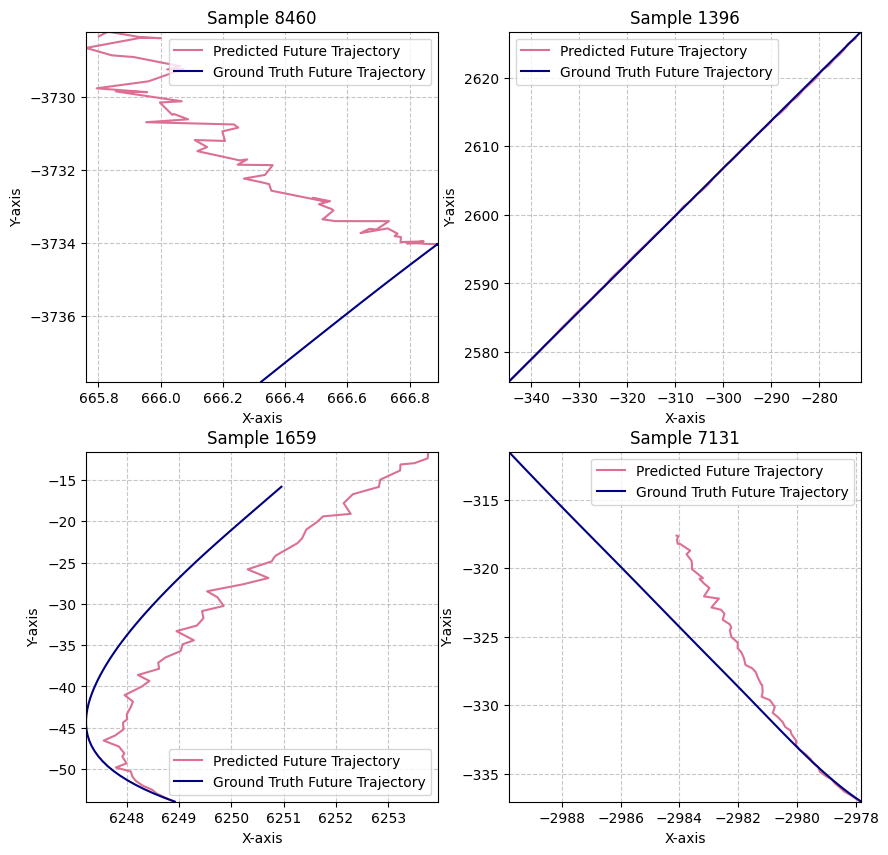

In [104]:
model = get_model()
if not isinstance(model, SceneContextModel):
    # LSTM can handle the timeseries data directly
    # TrajectoryDataset expects numpy arrays
    collate_func = lambda x: Batch.from_data_list(x)
    train_dataset = TrajectoryDatasetTrain(train_data, scale=scale, augment=True)
else:
    train_x: np.ndarray = train_data[..., :50, :]
    train_y: np.ndarray = train_data[:, 0, 50:, :2]
    X_train_tensor = torch.FloatTensor(train_x).reshape((-1, input_features))
    y_train_tensor = torch.FloatTensor(train_y).reshape((-1, output_features))
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

visualize_predictions(model, train_dataset)